# Implementing Logistic Classifier & Test the model on Amazon Product Review data set

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from math import sqrt
import json
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# pd.read_csv intelligently converts input to python datatypes.
products = pd.read_csv("amazon_baby_subset.csv")
products = products.astype(str)
print ('Shape : ', products.shape)
products.head()

Shape :  (53072, 4)


,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [3]:
# Change format of feature
products['rating'] = products['rating'].astype(int)
products['sentiment'] = products['sentiment'].astype(int)
#fill in N/A's in the review column
products = products.fillna({'reveiw':''}) 

In [4]:
#Write a function remove_punctuation that takes a line of text and removes all punctuation from that text
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation)

products['review_clean'] = products['review'].apply(remove_punctuation)

In [5]:
#read "important_words.json" file
with open('important_words.json') as data_file:
    important_words = json.load(data_file)

print('Number of importatnt words : ', len(important_words))

Number of importatnt words :  193


In [6]:
#now we proceed with the second item. For each word in important_words, 
#we compute a count for the number of times the word occurs in the review.
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s: s.split().count(word))

In [7]:
train_data = products.sample(frac=0.8,random_state=1)
validation_data = products.drop(train_data.index)

In [8]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    features_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(features_matrix, label_array)

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

print ('Input feature(X) : ', feature_matrix_train.shape, 'Output(y) : ', sentiment_train.shape)

Input feature(X) :  (42458, 194) Output(y) :  (42458,)


## Building a logistic regression

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [133]:
class logistic_classifier():
    def __init__(self):
        self.coefficients = np.zeros(1)
        self.l2_penalty = 0;
        self.iteration = 1000
        self.learning_rate = 1e-2
    
    def predict_probability(self, feature_matrix):
        #Take dot product of feature_matrix and coefficients
        score = np.dot(feature_matrix, self.coefficients)
        #Compute P(y_i = +1|x_i, w) using the link function
        predictions = 1/(1+np.exp(-score))
        return predictions
    
    #Compute derivative of log likelihood with respect to a single coefficient
    def feature_derivative_with_L2(self, errors, feature, coefficient, feature_is_constant):
        #Compute the dot product of errors and feature(without L2 penalty)
        derivative = np.dot(errors, feature)

        #add L2 penalty term for any feature that isn't the intercept
        if not feature_is_constant:
            derivative = derivative - (2*self.l2_penalty*coefficient)
        return derivative
    
    def compute_log_likelihood_with_L2(self, feature_matrix, sentiment):
        indicator = (sentiment == +1)
        scores = np.dot(feature_matrix, self.coefficients)
        lp = np.sum((indicator-1) * scores - np.log(1. + np.exp(-scores))) - self.l2_penalty*np.sum(self.coefficients[1:]**2)
        return lp
    
    def fit(self, feature_matrix, sentiment, learning_rate, l2_penalty, iteration):
        self.learning_rate = learning_rate
        self.l2_penalty = l2_penalty
        self.iteration = iteration
        self.coefficients = np.zeros(feature_matrix.shape[1])
        
        for itr in range(iteration):
            #Predict P(y_i = +1|x_1,w) using your predict_probability() function
            predictions = self.predict_probability(feature_matrix)

            #compute indicator value for (y_i = +1)
            indicator = (sentiment == +1)

            #Compute the errors as indicator - predictions
            errors = indicator - predictions
        
            for j in range(len(self.coefficients)): #loop over each coefficient
                is_intercept = (j==0)
                #Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
                #compute the derivative for coefficients[j]. Save it in a variable called derivative
                derivative = self.feature_derivative_with_L2(errors, feature_matrix[:,j], self.coefficients[j], is_intercept)
                #add step size times the derivative to the current coefficient(l2_penalty is already added)
                self.coefficients[j] = self.coefficients[j] + (learning_rate * derivative)

            #Checking whether log likelihood is increasing
            if (itr <= 100 and itr %10 ==0) or \
                (itr <= 1000 and itr %100 ==0) or (itr <= 10000 and itr %1000 ==0) or itr % 10000 ==0:
                    lp = self.compute_log_likelihood_with_L2(feature_matrix, sentiment)
                    print ('iteration %*d : log likelihood of observed labels = %.8f' % \
                    (int(np.ceil(np.log10(iteration ))), itr, lp))
       
    def get_accuracy(self, feature_matrix, sentiment):
        #compute scores using feature_matrix, coefficients
        scores = np.dot(feature_matrix, self.coefficients)
        #threshold scores by 0
        positive = scores > 0
        negative = scores <= 0
        scores[positive] = 1
        scores[negative] = -1

        correct = float((scores == sentiment).sum())
        total = float(len(sentiment))
        accuracy = float(correct / total)
        return accuracy

In [134]:
learning_rate = 5e-6
iteration = 501

l2_penalty = 0
model_0_penalty = logistic_classifier()
model_0_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

iteration   0 : log likelihood of observed labels = -29288.58070881
iteration  10 : log likelihood of observed labels = -28100.36448893
iteration  20 : log likelihood of observed labels = -27195.76986436
iteration  30 : log likelihood of observed labels = -26482.20092869
iteration  40 : log likelihood of observed labels = -25903.87524714
iteration  50 : log likelihood of observed labels = -25424.50160040
iteration  60 : log likelihood of observed labels = -25019.69333753
iteration  70 : log likelihood of observed labels = -24672.53647000
iteration  80 : log likelihood of observed labels = -24370.95069989
iteration  90 : log likelihood of observed labels = -24106.07783302
iteration 100 : log likelihood of observed labels = -23871.26902710
iteration 200 : log likelihood of observed labels = -22439.45278252
iteration 300 : log likelihood of observed labels = -21740.13826224
iteration 400 : log likelihood of observed labels = -21318.91399836
iteration 500 : log likelihood of observed label

In [135]:
l2_penalty = 4
model_4_penalty = logistic_classifier()
model_4_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

iteration   0 : log likelihood of observed labels = -29288.58355612
iteration  10 : log likelihood of observed labels = -28100.89790069
iteration  20 : log likelihood of observed labels = -27197.44526920
iteration  30 : log likelihood of observed labels = -26485.36508272
iteration  40 : log likelihood of observed labels = -25908.72932787
iteration  50 : log likelihood of observed labels = -25431.16298233
iteration  60 : log likelihood of observed labels = -25028.22888633
iteration  70 : log likelihood of observed labels = -24682.98137776
iteration  80 : log likelihood of observed labels = -24383.31964787
iteration  90 : log likelihood of observed labels = -24120.37188823
iteration 100 : log likelihood of observed labels = -23887.48005994
iteration 200 : log likelihood of observed labels = -22473.64467944
iteration 300 : log likelihood of observed labels = -21789.83285554
iteration 400 : log likelihood of observed labels = -21382.01826921
iteration 500 : log likelihood of observed label

In [136]:
l2_penalty = 10
model_10_penalty = logistic_classifier()
model_10_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

iteration   0 : log likelihood of observed labels = -29288.58782709
iteration  10 : log likelihood of observed labels = -28101.69749248
iteration  20 : log likelihood of observed labels = -27199.95513612
iteration  30 : log likelihood of observed labels = -26490.10227223
iteration  40 : log likelihood of observed labels = -25915.99217920
iteration  50 : log likelihood of observed labels = -25441.12402898
iteration  60 : log likelihood of observed labels = -25040.98490709
iteration  70 : log likelihood of observed labels = -24698.58170274
iteration  80 : log likelihood of observed labels = -24401.78292929
iteration  90 : log likelihood of observed labels = -24141.69645799
iteration 100 : log likelihood of observed labels = -23911.65056165
iteration 200 : log likelihood of observed labels = -22524.33977212
iteration 300 : log likelihood of observed labels = -21863.11893035
iteration 400 : log likelihood of observed labels = -21474.60080803
iteration 500 : log likelihood of observed label

In [137]:
l2_penalty = 1e2
model_1e2_penalty = logistic_classifier()
model_1e2_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

iteration   0 : log likelihood of observed labels = -29288.65189165
iteration  10 : log likelihood of observed labels = -28113.61600449
iteration  20 : log likelihood of observed labels = -27237.14100784
iteration  30 : log likelihood of observed labels = -26559.87687636
iteration  40 : log likelihood of observed labels = -26022.35455298
iteration  50 : log likelihood of observed labels = -25586.17892031
iteration  60 : log likelihood of observed labels = -25225.70914514
iteration  70 : log likelihood of observed labels = -24923.25613858
iteration  80 : log likelihood of observed labels = -24666.24743739
iteration  90 : log likelihood of observed labels = -24445.50675878
iteration 100 : log likelihood of observed labels = -24254.17809676
iteration 200 : log likelihood of observed labels = -23207.36014212
iteration 300 : log likelihood of observed labels = -22806.07339426
iteration 400 : log likelihood of observed labels = -22616.79550950
iteration 500 : log likelihood of observed label

In [138]:
l2_penalty = 1e3
model_1e3_penalty = logistic_classifier()
model_1e3_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

iteration   0 : log likelihood of observed labels = -29289.29253721
iteration  10 : log likelihood of observed labels = -28225.38392135
iteration  20 : log likelihood of observed labels = -27565.60803642
iteration  30 : log likelihood of observed labels = -27142.48892406
iteration  40 : log likelihood of observed labels = -26864.46318305
iteration  50 : log likelihood of observed labels = -26678.12176353
iteration  60 : log likelihood of observed labels = -26551.18435741
iteration  70 : log likelihood of observed labels = -26463.53995367
iteration  80 : log likelihood of observed labels = -26402.33551112
iteration  90 : log likelihood of observed labels = -26359.17953482
iteration 100 : log likelihood of observed labels = -26328.49445411
iteration 200 : log likelihood of observed labels = -26251.17254324
iteration 300 : log likelihood of observed labels = -26247.26212255
iteration 400 : log likelihood of observed labels = -26247.00705893
iteration 500 : log likelihood of observed label

In [139]:
l2_penalty = 1e5
model_1e5_penalty = logistic_classifier()
model_1e5_penalty.fit(feature_matrix_train, sentiment_train, learning_rate, l2_penalty, iteration)

iteration   0 : log likelihood of observed labels = -29359.76354881
iteration  10 : log likelihood of observed labels = -29359.43842752
iteration  20 : log likelihood of observed labels = -29359.34281077
iteration  30 : log likelihood of observed labels = -29359.30813393
iteration  40 : log likelihood of observed labels = -29359.29555782
iteration  50 : log likelihood of observed labels = -29359.29099689
iteration  60 : log likelihood of observed labels = -29359.28934279
iteration  70 : log likelihood of observed labels = -29359.28874290
iteration  80 : log likelihood of observed labels = -29359.28852534
iteration  90 : log likelihood of observed labels = -29359.28844644
iteration 100 : log likelihood of observed labels = -29359.28841783
iteration 200 : log likelihood of observed labels = -29359.28840154
iteration 300 : log likelihood of observed labels = -29359.28840154
iteration 400 : log likelihood of observed labels = -29359.28840154
iteration 500 : log likelihood of observed label

# Visualize the result

In [140]:
#but we gonna use this DataFrame
table = pd.DataFrame({'word': important_words, 'l2_penalty_0': model_0_penalty.coefficients[1:],
                  'l2_penalty_4': model_4_penalty.coefficients[1:], 'l2_penalty_10': model_10_penalty.coefficients[1:],
                  'l2_penalty_1e2': model_1e2_penalty.coefficients[1:], 'l2_penalty_1e3': model_1e3_penalty.coefficients[1:], 'l2_penalty_1e5': model_1e5_penalty.coefficients[1:]})

In [141]:
table = table.sort_values(['l2_penalty_0'], ascending=[0])
positive_words = table[1:6]['word']
negative_words = table[-6:-1]['word']
print ('Positive words : \n', positive_words)
print ('Negative words : \n', negative_words)

Positive words : 
 22      loves
7        easy
2       great
33    perfect
82      happy
Name: word, dtype: object
Negative words : 
 99          thought
168        returned
96            money
113          return
105    disappointed
Name: word, dtype: object


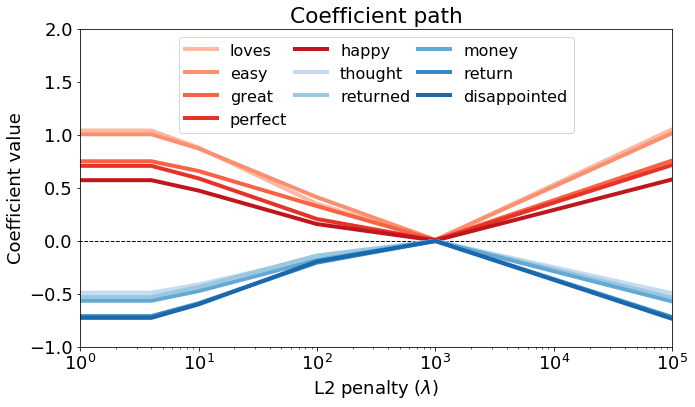

In [142]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words.iloc[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words.iloc[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [143]:
def get_accuracy(feature_matrix, coefficients, sentiment):
    #compute scores using feature_matrix, coefficients
    scores = np.dot(feature_matrix, coefficients)
    #threshold scores by 0
    positive = scores > 0
    negative = scores <= 0
    scores[positive] = 1
    scores[negative] = -1

    correct = float((scores == sentiment).sum())
    total = float(len(sentiment))
    accuracy = float(correct / total)
    return accuracy

In [144]:
accuracy_0_penalty = model_0_penalty.get_accuracy(feature_matrix_train, sentiment_train)
accuracy_4_penalty = model_4_penalty.get_accuracy(feature_matrix_train, sentiment_train)
accuracy_10_penalty = model_10_penalty.get_accuracy(feature_matrix_train, sentiment_train)
accuracy_1e2_penalty = model_1e2_penalty.get_accuracy(feature_matrix_train, sentiment_train)
accuracy_1e3_penalty = model_1e3_penalty.get_accuracy(feature_matrix_train, sentiment_train)
accuracy_1e5_penalty = model_1e5_penalty.get_accuracy(feature_matrix_train, sentiment_train)

In [145]:
print (accuracy_0_penalty, accuracy_4_penalty, accuracy_10_penalty, accuracy_1e2_penalty, accuracy_1e3_penalty, accuracy_1e5_penalty, sep='\n')

0.7687126101088134
0.7685712939846436
0.7685241886099204
0.7680531348626878
0.7574308728625936
0.6627490696688492


In [146]:
accuracy_0_penalty_valid = model_0_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
accuracy_4_penalty_valid = model_4_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
accuracy_10_penalty_valid = model_10_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
accuracy_1e2_penalty_valid = model_1e2_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
accuracy_1e3_penalty_valid = model_1e3_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)
accuracy_1e5_penalty_valid = model_1e5_penalty.get_accuracy(feature_matrix_valid, sentiment_valid)

In [147]:
print (accuracy_0_penalty_valid, accuracy_4_penalty_valid, accuracy_10_penalty_valid, accuracy_1e2_penalty_valid, accuracy_1e3_penalty_valid, accuracy_1e5_penalty_valid, sep='\n')

0.7697380817787828
0.7699265121537592
0.7702091577162239
0.7695496514038063
0.7581496137177313
0.6643112869794611
